In [42]:
from os import listdir
from dotenv import dotenv_values
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

exp_path = '../experiments'
decagon_AUPRC = 0.832
transductive_AUPRC = 0.971
emerGNN_cold = 0.814
emerGNN_warm = 0.906

In [43]:
def load_results(result_filename, exp_path='../experiments', target_len=963*3):
    out = []
    for loc1 in ['MAP4', 'RDK', 'morgan']:
        neighbour_method = loc1
        for loc2 in listdir(f'{exp_path}/{loc1}'):
            nearest_n = int(loc2.split('_n')[-1])
            for loc3 in listdir(f'{exp_path}/{loc1}/{loc2}'):
                if loc3.startswith('2024'):
                    load_path = f'{exp_path}/{loc1}/{loc2}/{loc3}/{result_filename}'
                    df = pd.read_csv(load_path)
                    if len(df) > target_len:
                        df = df.drop_duplicates()
                        assert len(df) == target_len
                        df.to_csv(load_path)
                    df['psi'] = float(loc3.split('psi_')[-1])
                    df['neighbourhood'] = neighbour_method if neighbour_method != 'morgan' else 'Morgan'
                    df['nearest_n'] = nearest_n
                    df['Training'] = 'OOS-KGE'
                    out.append(df)
    return out

# Actual PPSE performance by psi value

In [44]:
# Read polySE results using aggregations in place of embeddings
polySE_true_dfs = load_results('polySE_results_real_embeds.csv')

# Also read equivalent results from chapter 3
chap3_path = dotenv_values()['THESIS_PATH'] + '/Chapter3/analysis/assessment/best_trials_assess/20230929-111630-simple_selfloops/results_full.csv'
df_c3 = pd.read_csv(chap3_path)
df_c3['psi'] = 0.0
df_c3['neighbourhood'] = 'N/A (Chapter 3 results)'
df_c3['nearest_n'] = 'N/A (Chapter 3 results)'
df_c3['Training'] = 'SimplE (Chapter 3 results)'
polySE_true_dfs.append(df_c3)

polySE_true = pd.concat(polySE_true_dfs)
polySE_true

,Relation,AUROC,AUPRC,AP@50,psi,neighbourhood,nearest_n,Training
0,C0005779,0.962682,0.953026,1.000000,0.25,MAP4,5,OOS-KGE
1,C0011991,0.958266,0.940556,0.967104,0.25,MAP4,5,OOS-KGE
2,C0011860,0.968854,0.955512,0.952080,0.25,MAP4,5,OOS-KGE
3,C0038395,0.965226,0.954268,1.000000,0.25,MAP4,5,OOS-KGE
4,C1145670,0.954717,0.936727,0.958807,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...
958,C0016665,0.995556,0.996028,1.000000,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),SimplE (Chapter 3 results)
959,C0006846,0.996618,0.996923,1.000000,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),SimplE (Chapter 3 results)
960,C0025637,0.995932,0.995983,0.978775,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),SimplE (Chapter 3 results)
961,C0426636,0.996998,0.996954,1.000000,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),SimplE (Chapter 3 results)


In [45]:
for tup, subdf in polySE_true.groupby(['psi', 'nearest_n', 'neighbourhood']):
    print(f'At parameters {tup}, median AUPRC = {subdf.AUPRC.median():.5f}')

At parameters (0.0, 'N/A (Chapter 3 results)', 'N/A (Chapter 3 results)'), median AUPRC = 0.97138
At parameters (0.125, 5, 'MAP4'), median AUPRC = 0.95809
At parameters (0.125, 5, 'Morgan'), median AUPRC = 0.95812
At parameters (0.125, 5, 'RDK'), median AUPRC = 0.95811
At parameters (0.125, 10, 'MAP4'), median AUPRC = 0.95898
At parameters (0.125, 10, 'Morgan'), median AUPRC = 0.95760
At parameters (0.125, 10, 'RDK'), median AUPRC = 0.95834
At parameters (0.125, 20, 'MAP4'), median AUPRC = 0.95671
At parameters (0.125, 20, 'Morgan'), median AUPRC = 0.95779
At parameters (0.125, 20, 'RDK'), median AUPRC = 0.95760
At parameters (0.25, 5, 'MAP4'), median AUPRC = 0.95705
At parameters (0.25, 5, 'Morgan'), median AUPRC = 0.95638
At parameters (0.25, 5, 'RDK'), median AUPRC = 0.95791
At parameters (0.25, 10, 'MAP4'), median AUPRC = 0.95700
At parameters (0.25, 10, 'Morgan'), median AUPRC = 0.95798
At parameters (0.25, 10, 'RDK'), median AUPRC = 0.95747
At parameters (0.25, 20, 'MAP4'), media

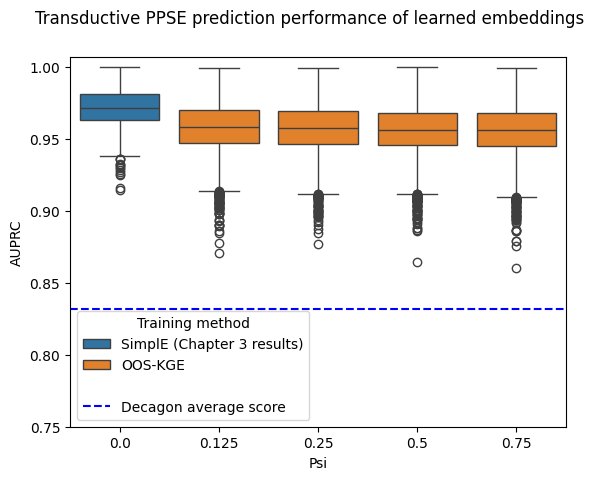

In [46]:
plt.clf()
sns.boxplot(polySE_true, x='psi', y='AUPRC', hue='Training')
xmin = -0.5
xmax = 4.5

plt.suptitle('Transductive PPSE prediction performance of learned embeddings')
plt.xlabel('Psi')
plt.ylim(bottom=0.75)
plt.xlim(xmin, xmax)
plt.hlines(10, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')
plt.hlines(decagon_AUPRC, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='Decagon average score')
plt.legend(title='Training method')
plt.savefig('polySE_true_embeds.png')

In [47]:
for psi, subdf in polySE_true.groupby('psi'):
    print(psi, subdf.AUPRC.median())

print(polySE_true.query('psi > 0').AUPRC.median())

0.0 0.9713806704150786
0.125 0.9578854551550212
0.25 0.9573736711158544
0.5 0.956248779133881
0.75 0.9559182023946324
0.9568926213850356


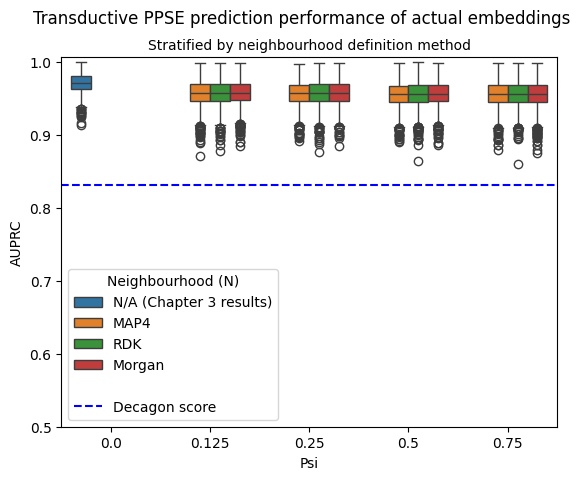

In [48]:
plt.clf()
sns.boxplot(polySE_true, x='psi', y='AUPRC', hue='neighbourhood')
xmin = -0.5
xmax = 4.5

plt.suptitle('Transductive PPSE prediction performance of actual embeddings')
plt.title('Stratified by neighbourhood definition method', size=10)
plt.xlabel('Psi')
plt.ylim(bottom=0.5)
plt.xlim(xmin, xmax)
plt.hlines(10, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')
plt.hlines(decagon_AUPRC, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='Decagon score')
plt.legend(title='Neighbourhood (N)')
plt.savefig('polySE_true_embeds_by_neighbourhood_method.png')

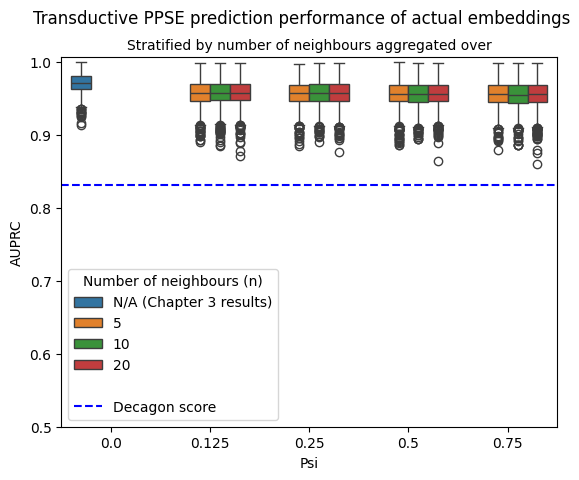

In [49]:
plt.clf()
sns.boxplot(polySE_true, x='psi', y='AUPRC', hue='nearest_n')
xmin = -0.5
xmax = 4.5

plt.suptitle('Transductive PPSE prediction performance of actual embeddings')
plt.title('Stratified by number of neighbours aggregated over', size=10)
plt.xlabel('Psi')
plt.ylim(bottom=0.5)
plt.xlim(xmin, xmax)
plt.hlines(10, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')
plt.hlines(decagon_AUPRC, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='Decagon score')
plt.legend(title='Number of neighbours (n)')
plt.savefig('polySE_true_embeds_by_num_neighbours.png')

# Cosine similarities of aggregated vectors to true embeddings

In [50]:
# Read cosine data
cosine_dfs = load_results('cosines_vs_actual.csv')

# Also read equivalent results from chapter 4
chap4_path = dotenv_values()['THESIS_PATH'] + '/Chapter4/data/results/cosines_vs_actual.csv'
df_c4= pd.read_csv(chap4_path)
df_c4 = df_c4.query('vector_method == "mean components" and neighbourhood_method == "drug similarity"')
df_c4['psi'] = 0.0
df_c4['Training'] = 'Standard SimplE'
df_c4['cosine_to_actual'] = df_c4['cosine_sim']
df_c4['neighbourhood'] = 'N/A (Chapter 4 results)'
df_c4['nearest_n'] = 'N/A (Chapter 4 results)'
df_c4.drop(columns=['cosine_sim'], inplace=True)
cosine_dfs.append(df_c4)

cosines = pd.concat(cosine_dfs)
cosines

,drug,neighbourhood_method,vector_method,cosine_to_actual,psi,neighbourhood,nearest_n,Training
0,CID000003954,drug similarity,mean components,0.627120,0.25,MAP4,5,OOS-KGE
1,CID000004829,drug similarity,mean components,0.575273,0.25,MAP4,5,OOS-KGE
2,CID000004140,drug similarity,mean components,0.534625,0.25,MAP4,5,OOS-KGE
3,CID000002909,drug similarity,mean components,0.538957,0.25,MAP4,5,OOS-KGE
4,CID000003676,drug similarity,mean components,0.463523,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...,...,...
5467,CID006435110,drug similarity,mean components,0.717333,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE
5479,CID006436173,drug similarity,mean components,0.499533,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE
5485,CID006447131,drug similarity,mean components,0.604204,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE
5491,CID006918453,drug similarity,mean components,0.588499,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE


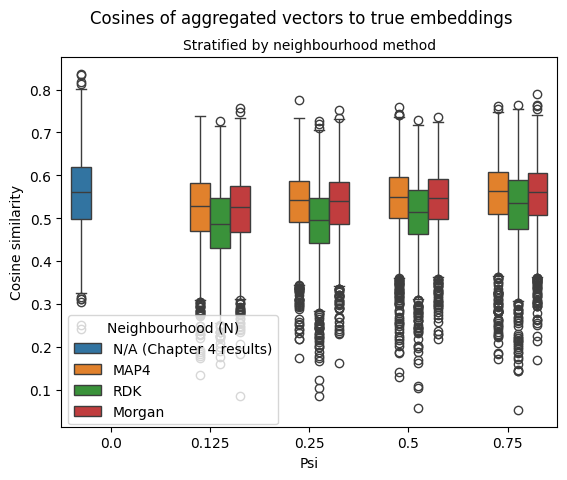

In [51]:
plt.clf()
sns.boxplot(cosines, x='psi', y='cosine_to_actual', hue='neighbourhood')
plt.suptitle('Cosines of aggregated vectors to true embeddings')
plt.title('Stratified by neighbourhood method', size=10)
plt.xlabel('Psi')
plt.ylabel('Cosine similarity')
plt.legend(bbox_to_anchor=(0.45, 0.32), title='Neighbourhood (N)')
plt.savefig('cosines_vs_actual_by_neighbourhood.png', bbox_inches='tight')

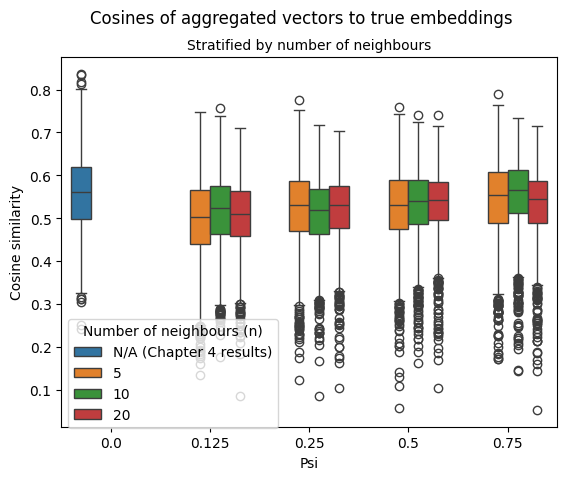

In [52]:
plt.clf()
sns.boxplot(cosines, x='psi', y='cosine_to_actual', hue='nearest_n')
plt.suptitle('Cosines of aggregated vectors to true embeddings')
plt.title('Stratified by number of neighbours', size=10)
plt.xlabel('Psi')
plt.ylabel('Cosine similarity')
plt.legend(bbox_to_anchor=(0.45, 0.3106), title='Number of neighbours (n)')
plt.savefig('cosines_vs_actual_by_num_neighbours.png', bbox_inches='tight')

# PPSE performance using the aggregated vectors

In [53]:
# Read polySE results from using aggregations
polySE_agg_dfs = load_results('polySE_results_aggregations.csv')


# Also read equivalent results from chapter 3
chap4_agg_path = dotenv_values()['THESIS_PATH'] + '/Chapter4/data/results/polySE.csv'
chap4_agg = pd.read_csv(chap4_agg_path)
chap4_agg = chap4_agg.query('vector_method == "mean components" and neighbourhood_method == "drug similarity"')
chap4_agg['psi'] = 0.0
chap4_agg['Training'] = 'Standard SimplE'
chap4_agg['neighbourhood'] = 'N/A (Chapter 4 results)'
chap4_agg['nearest_n'] = 'N/A (Chapter 4 results)'
chap4_agg.drop(columns=['neighbourhood_method', 'vector_method'], inplace=True)
polySE_agg_dfs.append(chap4_agg)

polySE_agg = pd.concat(polySE_agg_dfs)
polySE_agg

,side_effect,fake_triple_component,AUROC,AUPRC,AP50,psi,neighbourhood,nearest_n,Training,Unnamed: 0
0,C0000737,head,0.680286,0.660418,0.530202,0.25,MAP4,5,OOS-KGE,NaN
1,C0000737,tail,0.699077,0.690007,0.824252,0.25,MAP4,5,OOS-KGE,NaN
2,C0000737,both,0.569388,0.546916,0.279839,0.25,MAP4,5,OOS-KGE,NaN
3,C0000768,head,0.841712,0.803508,0.667005,0.25,MAP4,5,OOS-KGE,NaN
4,C0000768,tail,0.854411,0.813278,0.803771,0.25,MAP4,5,OOS-KGE,NaN
...,...,...,...,...,...,...,...,...,...,...
23080,C0005001,head,0.759702,0.745933,0.902196,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE,NaN
23081,C0005001,tail,0.841094,0.828883,0.939010,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE,NaN
23103,C0020625,both,0.568307,0.549721,0.240306,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE,NaN
23104,C0020625,head,0.790351,0.766044,0.950610,0.00,N/A (Chapter 4 results),N/A (Chapter 4 results),Standard SimplE,NaN


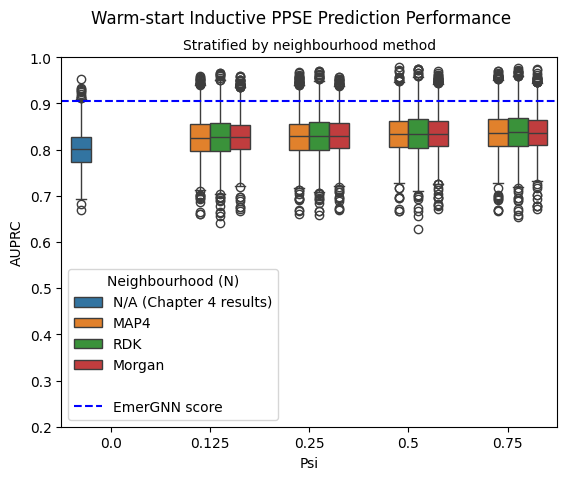

In [54]:
warm_start = polySE_agg.query('fake_triple_component != "both"')
sns.boxplot(warm_start, x='psi', y='AUPRC', hue='neighbourhood')

xmin = -0.5
xmax = 4.5
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_warm, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1)
plt.xlim(xmin, xmax)
plt.legend()
plt.suptitle('Warm-start Inductive PPSE Prediction Performance')
plt.title('Stratified by neighbourhood method', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.legend(title='Neighbourhood (N)')
plt.savefig('polySE_agg_warm_start_by_neighbourhood.png')

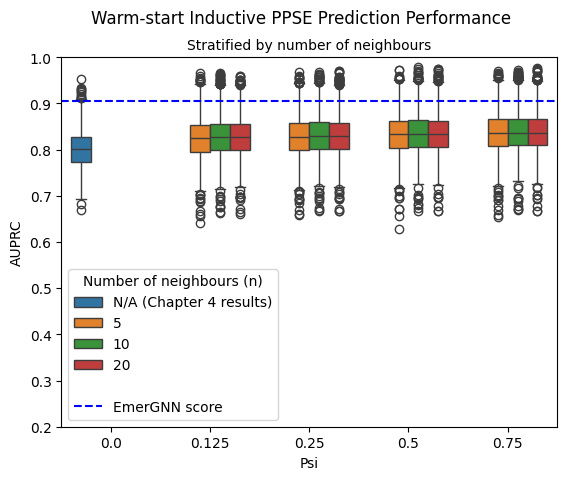

In [55]:
warm_start = polySE_agg.query('fake_triple_component != "both"')
sns.boxplot(warm_start, x='psi', y='AUPRC', hue='nearest_n')

xmin = -0.5
xmax = 4.5
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_warm, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.2, 1)
plt.xlim(xmin, xmax)
plt.legend()
plt.suptitle('Warm-start Inductive PPSE Prediction Performance')
plt.title('Stratified by number of neighbours', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.legend(title='Number of neighbours (n)')
plt.savefig('polySE_agg_warm_start_by_num_neighbours.png')

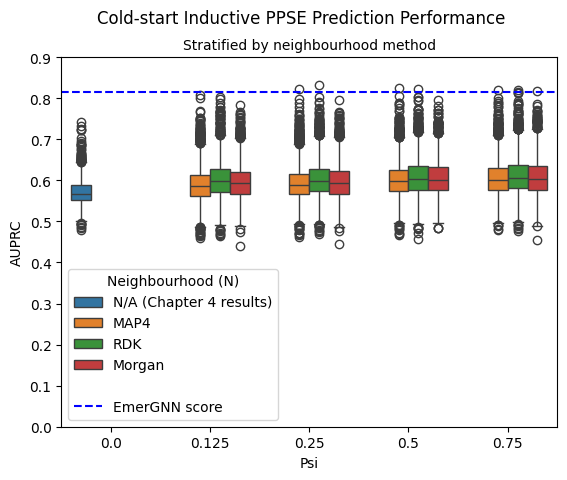

In [56]:
cold_start = polySE_agg.query('fake_triple_component == "both"')
sns.boxplot(cold_start, x='psi', y='AUPRC', hue='neighbourhood')

xmin = -0.5
xmax = 4.5
plt.xlim(xmin, xmax)
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_cold, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0.0, 0.9)
plt.legend()
plt.suptitle('Cold-start Inductive PPSE Prediction Performance')
plt.title('Stratified by neighbourhood method', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.legend(title='Neighbourhood (N)')
plt.savefig('polySE_agg_cold_start_by_neighbourhood.png')

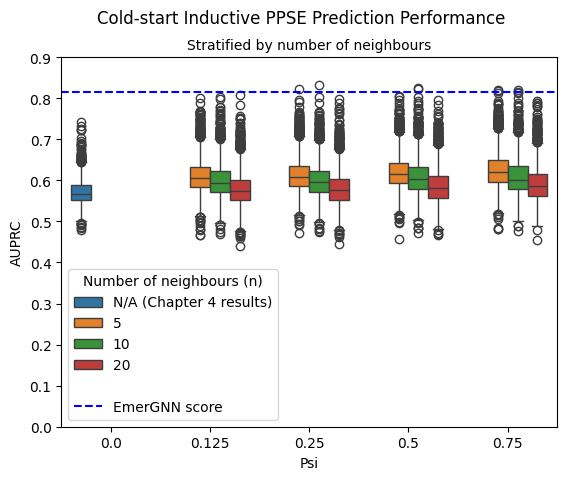

In [57]:
cold_start = polySE_agg.query('fake_triple_component == "both"')
sns.boxplot(cold_start, x='psi', y='AUPRC', hue='nearest_n')

xmin = -0.5
xmax = 4.5
plt.xlim(xmin, xmax)
plt.hlines(-2, xmin=xmin, xmax=xmax, colors='white', linestyles='dashed', label=' ')  # To add gap in legend
plt.hlines(emerGNN_cold, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='EmerGNN score')
plt.ylim(0, 0.9)
plt.legend()
plt.suptitle('Cold-start Inductive PPSE Prediction Performance')
plt.title('Stratified by number of neighbours', size=10)
plt.xlabel('Psi')

#plt.tight_layout()
plt.legend(title='Number of neighbours (n)')
plt.savefig('polySE_agg_cold_start_by_num_neighbours.png')

# Bits of analysis for paper and stuff

In [58]:
warm_OOS = polySE_agg.query('Training != "Standard LibKGE training" and fake_triple_component != "both"')
warm_standard = polySE_agg.query('Training == "Standard LibKGE training" and fake_triple_component != "both"')

print('Warm start: chapter 4 vs chapter 5:\n')
print(f'Standard LibKGE median AUPRC = {warm_standard.AUPRC.median()}')
for psi, subdf in warm_OOS.groupby('psi'):
    print(f'OOS psi = {psi}, median AUPRC = {subdf.AUPRC.median()}')

Warm start: chapter 4 vs chapter 5:

Standard LibKGE median AUPRC = nan
OOS psi = 0.0, median AUPRC = 0.8005534279019861
OOS psi = 0.125, median AUPRC = 0.8262047860659409
OOS psi = 0.25, median AUPRC = 0.8289453148169468
OOS psi = 0.5, median AUPRC = 0.8334494095981713
OOS psi = 0.75, median AUPRC = 0.8362913005860739


In [59]:
cold_OOS = polySE_agg.query('Training != "Standard LibKGE training" and fake_triple_component == "both"')
cold_standard = polySE_agg.query('Training == "Standard LibKGE training" and fake_triple_component == "both"')


print('Cold start: chapter 4 vs chapter 5:\n')
print(f'Standard LibKGE median AUPRC = {cold_standard.AUPRC.median()}')
for tup, subdf in cold_OOS.groupby(['psi','nearest_n']):
    print(f'OOS psi = {tup[0]}, num_neighbours = {tup[1]}, median AUPRC = {subdf.AUPRC.median()}')

Cold start: chapter 4 vs chapter 5:

Standard LibKGE median AUPRC = nan
OOS psi = 0.0, num_neighbours = N/A (Chapter 4 results), median AUPRC = 0.5678348031246792
OOS psi = 0.125, num_neighbours = 5, median AUPRC = 0.6066111431203117
OOS psi = 0.125, num_neighbours = 10, median AUPRC = 0.5945255931314806
OOS psi = 0.125, num_neighbours = 20, median AUPRC = 0.57310039335931
OOS psi = 0.25, num_neighbours = 5, median AUPRC = 0.6076605382965242
OOS psi = 0.25, num_neighbours = 10, median AUPRC = 0.5947676474828432
OOS psi = 0.25, num_neighbours = 20, median AUPRC = 0.5756273460351693
OOS psi = 0.5, num_neighbours = 5, median AUPRC = 0.6152714108880779
OOS psi = 0.5, num_neighbours = 10, median AUPRC = 0.6026248983204898
OOS psi = 0.5, num_neighbours = 20, median AUPRC = 0.5808081150464431
OOS psi = 0.75, num_neighbours = 5, median AUPRC = 0.6192970061418406
OOS psi = 0.75, num_neighbours = 10, median AUPRC = 0.6019608532498884
OOS psi = 0.75, num_neighbours = 20, median AUPRC = 0.58654987

# Runtime analysis

In [60]:
# Load OOS experiment runtimes

runtimes_list = load_results('epoch_runtimes.csv')

runtimes = pd.concat(runtimes_list)
runtimes['Training'] = "OOS-KGE"
runtimes

,epoch,runtime,psi,neighbourhood,nearest_n,Training
0,1,367.916080,0.250,MAP4,5,OOS-KGE
1,2,373.009232,0.250,MAP4,5,OOS-KGE
2,3,368.799942,0.250,MAP4,5,OOS-KGE
3,4,370.225601,0.250,MAP4,5,OOS-KGE
4,5,371.512388,0.250,MAP4,5,OOS-KGE
...,...,...,...,...,...,...
45,46,510.682148,0.125,Morgan,10,OOS-KGE
46,47,510.549377,0.125,Morgan,10,OOS-KGE
47,48,519.018309,0.125,Morgan,10,OOS-KGE
48,49,522.089859,0.125,Morgan,10,OOS-KGE


In [61]:
# Load standard experiment runtimes
chap3_runtimes = pd.read_csv('../../../../Chapter3/analysis/experiments/runtimes/per_epoch_runtimes.csv')
chap3_runtimes.query('dataset == "selfloops" and model == "simple" and trial == 21', inplace=True)
chap3_runtimes.drop(columns=['dataset', 'model', 'trial'], inplace=True)
chap3_runtimes['psi'] = 0.0
chap3_runtimes['nearest_n'] = 'N/A (Chapter 3 results)'
chap3_runtimes['neighbourhood'] = 'N/A (Chapter 3 results)'
chap3_runtimes['Training'] = "Standard SimplE"

runtimes = pd.concat([runtimes, chap3_runtimes])
runtimes

,epoch,runtime,psi,neighbourhood,nearest_n,Training
0,1,367.916080,0.25,MAP4,5,OOS-KGE
1,2,373.009232,0.25,MAP4,5,OOS-KGE
2,3,368.799942,0.25,MAP4,5,OOS-KGE
3,4,370.225601,0.25,MAP4,5,OOS-KGE
4,5,371.512388,0.25,MAP4,5,OOS-KGE
...,...,...,...,...,...,...
20067,496,117.910016,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),Standard SimplE
20068,497,118.612354,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),Standard SimplE
20069,498,118.544523,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),Standard SimplE
20070,499,118.557972,0.00,N/A (Chapter 3 results),N/A (Chapter 3 results),Standard SimplE


/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_80175/279530549.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(runtimes, x='psi', y='runtime', hue='neighbourhood', ci='sd')


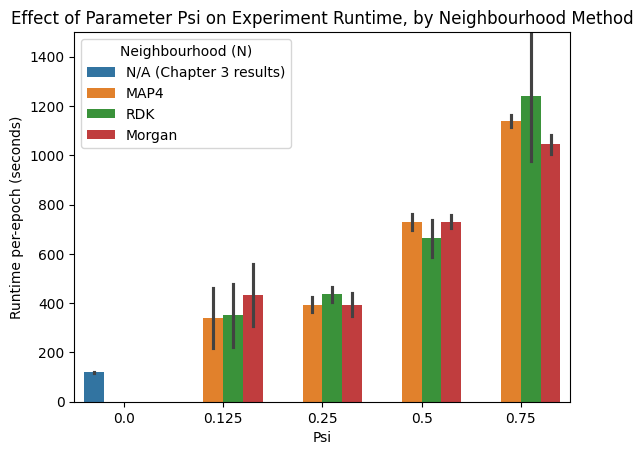

In [62]:
sns.barplot(runtimes, x='psi', y='runtime', hue='neighbourhood', ci='sd')
plt.ylim(0, 1500)
plt.xlabel('Psi')
plt.ylabel('Runtime per-epoch (seconds)')
plt.title('Effect of Parameter Psi on Experiment Runtime, by Neighbourhood Method')
plt.legend(title='Neighbourhood (N)')
plt.savefig('runtime_vs_chap3_by_neighbourhood.png')

/var/folders/_x/2pk9s5z166x9c0h399wmby_h0000gp/T/ipykernel_80175/3242925118.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(runtimes, x='psi', y='runtime', hue='nearest_n', ci='sd')


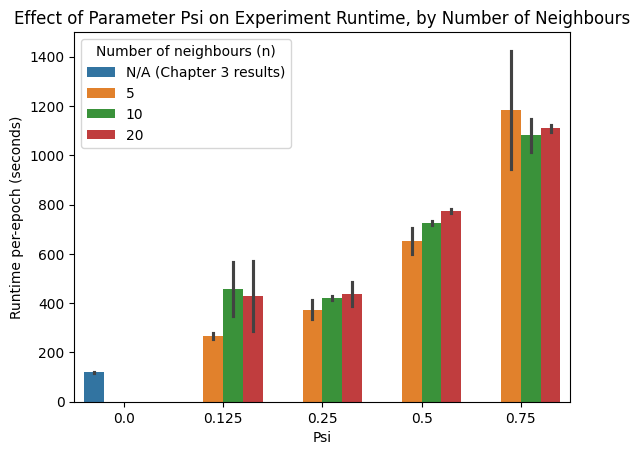

In [63]:
sns.barplot(runtimes, x='psi', y='runtime', hue='nearest_n', ci='sd')
plt.ylim(0, 1500)
plt.xlabel('Psi')
plt.ylabel('Runtime per-epoch (seconds)')
plt.title('Effect of Parameter Psi on Experiment Runtime, by Number of Neighbours')
plt.legend(title='Number of neighbours (n)')
plt.savefig('runtime_vs_chap3_by_num_neighbours.png')

# Post hoc node removal analysis

In [64]:
ad_hoc = pd.concat(load_results('polySE_results_aggregations.csv')).query('side_effect != "C0000731"')
post_hoc = pd.concat(load_results('polySE_posthoc_results_aggregations.csv')).query('side_effect != "C0000731"')

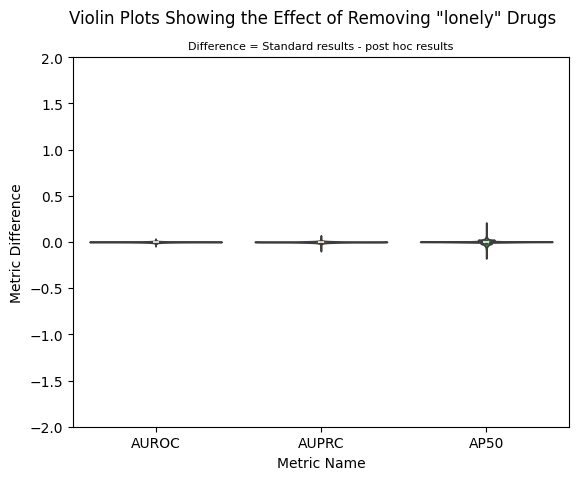

In [65]:
metrics = ['AUROC','AUPRC', 'AP50']
diff = ad_hoc[metrics] - post_hoc[metrics]

sns.violinplot(diff)
plt.ylim(-2, 2)
plt.xlabel('Metric Name')
plt.ylabel('Metric Difference')
plt.suptitle('Violin Plots Showing the Effect of Removing "lonely" Drugs')
plt.title('Difference = Standard results - post hoc results', size=8)
plt.savefig('posthoc_difference.png')

In [66]:
abs_diff = np.abs(diff)
print('AUROC median:', abs_diff.AUROC.median())
print('AUPRC median:', abs_diff.AUPRC.median())
print('AP50 median:', abs_diff.AP50.median())


AUROC median: 0.0020166056743967653
AUPRC median: 0.0026555909938945077
AP50 median: 0.0028437389229342136
